# FVGP MULTI Task Notebook
In this notebook we will go through many features of FVGP. We will be primarily concerned with regression over a single dimension output and multiple tasks.

## This first cell has nothing to do with gpCAM, it's just a fucntion to plot some results later

In [21]:
import plotly.graph_objects as go
import numpy as np
def plot(x,y,z,data = None):
    fig = go.Figure()
    fig.add_trace(go.Surface(x = x, y = y,z=z))
    if data is not None: 
        fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2],
                                   mode='markers'))

    fig.update_layout(title='Posterior Mean', autosize=True,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))


    fig.show()

## Import fvgp and relevant libraries

In [22]:
import fvgp
from fvgp import gp, fvgp
import sklearn
import numpy as np
import matplotlib.pyplot as plt

## Defining some input data and testing points

In [23]:
def test_data_function(x):
    data_1 = 100*np.sin(x)+np.cos(x)
    data_2 = 5*np.ones(x.shape)
    data_3 = 1*np.cos(x/10 + 5)
    data_4 = 5*np.sin(x/200)
    data_5 = 10*np.cos(x)
    
    return np.column_stack((data_1, data_2, data_3, data_4, data_5))


In [24]:
x_input = np.linspace(-2*np.pi, 10*np.pi,100)

In [25]:
y_output = test_data_function(x_input)

In [26]:
x_input_test = np.linspace(3*np.pi, 4*np.pi, 100)

## Setting up the fvgp multi task object


In [28]:
obj = fvgp.fvGP(input_space_dim = 1, 
                output_space_dim = 1, 
                output_number = 5, 
                points = x_input.reshape(-1,1),
                values = y_output,
               init_hyperparameters = np.array([10,10,10]))

CAUTION: fvGP reports that you have not provided data variances, they will set to be 1 percent of the data values!


## Training our gaussian process regression on given data


In [29]:
hyper_param_bounds = np.array([[0.0001, 1000],[ 0.0001, 1000],[ 0.0001, 1000]])
obj.train(hyper_param_bounds)

fvGP training started with  500  data points
fvGP hyperparameter tuning in progress. Old hyperparameters:  [10 10 10]  with old log likelihood:  60129.07537720439
method:  global
fvGP is performing a global differential evolution algorithm to find the optimal hyperparameters.
maximum number of iterations:  120
termination tolerance:  0.1
bounds:  [[1.e-04 1.e+03]
 [1.e-04 1.e+03]
 [1.e-04 1.e+03]]
differential_evolution step 1: f(x)= 14321.1
differential_evolution step 2: f(x)= 5614.44
differential_evolution step 3: f(x)= 2353.32
differential_evolution step 4: f(x)= 2353.32
differential_evolution step 5: f(x)= 2353.32
differential_evolution step 6: f(x)= 2353.32
differential_evolution step 7: f(x)= 2353.32
differential_evolution step 8: f(x)= 2353.32
differential_evolution step 9: f(x)= 2353.32
differential_evolution step 10: f(x)= 2088.3
differential_evolution step 11: f(x)= 1945.75
differential_evolution step 12: f(x)= 1945.75
differential_evolution step 13: f(x)= 1945.75
differentia

## Looking the posterior mean at the test points

In [64]:
task_idx = 1

In [74]:
x_linspace = np.linspace(3*np.pi, 4*np.pi,100)
y_linspace = np.linspace(0,4,100)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
post_mean= obj.posterior_mean(np.column_stack((x_input_test, task_idx*np.ones(x_input_test.shape))))
posterior_mean_data = obj.posterior_mean(np.column_stack((x_grid.flatten(), y_grid.flatten())))


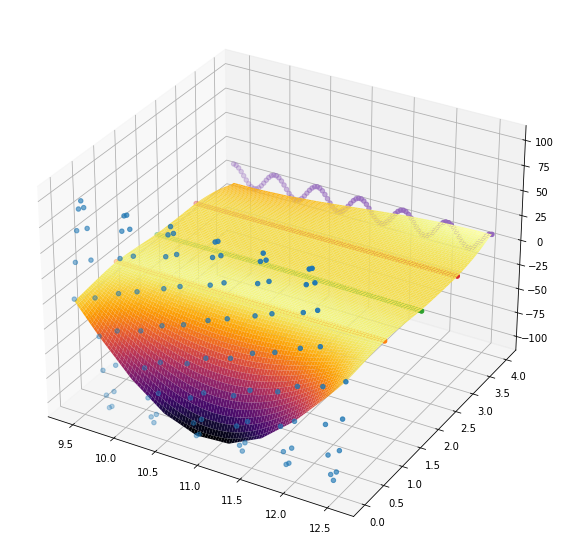

In [75]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')


ax.scatter(post_mean['x'][:,0], np.ones(100)*0, y_output[:,0])
ax.scatter(post_mean['x'][:,0], np.ones(100)*1,y_output[:,1])
ax.scatter(post_mean['x'][:,0], np.ones(100)*2,y_output[:,2])
ax.scatter(post_mean['x'][:,0], np.ones(100)*3,y_output[:,3])
ax.scatter(post_mean['x'][:,0], np.ones(100)*4,y_output[:,4])
ax.plot_surface(x_grid, y_grid, posterior_mean_data['f(x)'].reshape(100,100), rstride=1, cstride=1,cmap='inferno')
# ax.scatter(x_grid.flatten(), y_grid.flatten(), posterior_mean_data['f(x)'])

# pyplot.pcolormesh(x_grid, y_grid, posterior_mean_data['f(x)'].reshape(100,100))


In [45]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[
    go.Surface(x = x_grid, y = y_grid, z=posterior_mean_data['f(x)'].reshape(100,100))


])

fig.show()

# Training Asynchronously 

In [33]:
obj = gp.GP(input_space_dim = 1, points = x_input.reshape(-1,1),
                            values = y_output.reshape(-1,1),
                           init_hyperparameters = np.array([10,10]),
                            variances = np.zeros(y_output.reshape(-1,1).shape))


In [197]:
hyper_param_bounds = np.array([[0.0001, 100], [ 0.0001, 100]])

In [35]:
async_obj = obj.train_async(hyper_param_bounds)

Async fvGP training started with  100  data points
fvGP submitted HGDL optimization for asynchronous training
bounds: [[1.e-04 1.e+03]
 [1.e-04 1.e+03]]
HGDL starts with:  [[ 10.          10.        ]
 [849.74516529 383.96733595]
 [321.11918758 415.84576811]]


## Updating asynchronously
Updates hyperparameters to current optimization values

In [38]:
obj.update_hyperparameters(async_obj)

fvGP async hyperparameter update successful
Latest hyperparameters:  [1000.            1.47191746]


array([1000.        ,    1.47191746])

## Killing training 


In [39]:
obj.kill_training(async_obj)

fvGP is killing asynchronous training....
HGDL kill initialized ...
HGDL kill successful
fvGP successfully killed the training.


## Looking the posterior mean at the test points

In [40]:
post_mean= obj.posterior_mean(x_input_test.reshape(-1,1))

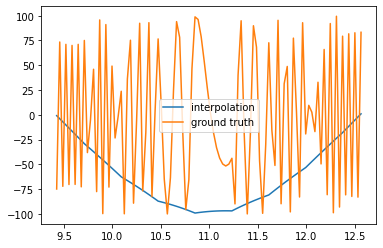

In [41]:
plt.plot(post_mean['x'], post_mean['f(x)'], label='interpolation')
plt.plot(post_mean['x'], test_data_function(post_mean['f(x)']), label='ground truth')
plt.legend()

# Custom Kernels

In [49]:
def kernel_l1(x1,x2, hp, obj):
    ################################################################
    ###standard anisotropic kernel in an input space with l1########
    ################################################################
    d1 = abs(np.subtract.outer(x1[:,0],x2[:,0])) 
    return hp[0] * np.exp(-d1/hp[1])

In [50]:
obj = gp.GP(input_space_dim = 1, points = x_input.reshape(-1,1),
                            values = y_output.reshape(-1,1),
                           init_hyperparameters = np.array([10,10]),
                            variances = np.zeros(y_output.reshape(-1,1).shape),
                            gp_kernel_function = kernel_l1)

## Training our gaussian process regression on given data


In [51]:
hyper_param_bounds = np.array([[0.0001, 1000],[ 0.0001, 1000]])
obj.train(hyper_param_bounds)

fvGP training started with  100  data points
fvGP hyperparameter tuning in progress. Old hyperparameters:  [10 10]  with old log likelihood:  47099.56438902898
method:  global
fvGP is performing a global differential evolution algorithm to find the optimal hyperparameters.
maximum number of iterations:  120
termination tolerance:  0.1
bounds:  [[1.e-04 1.e+03]
 [1.e-04 1.e+03]]
differential_evolution step 1: f(x)= 588.666
differential_evolution step 2: f(x)= 588.666
differential_evolution step 3: f(x)= 588.666
differential_evolution step 4: f(x)= 535.109
differential_evolution step 5: f(x)= 526.296
differential_evolution step 6: f(x)= 526.296
differential_evolution step 7: f(x)= 526.296
differential_evolution step 8: f(x)= 506.4
differential_evolution step 9: f(x)= 497.467
differential_evolution step 10: f(x)= 493.261
differential_evolution step 11: f(x)= 493.261
fvGP found hyperparameters  [1000.            1.47192176]  with likelihood  492.0289989061517  via global optimization


## Looking the posterior mean at the test points

In [52]:
post_mean= obj.posterior_mean(x_input_test.reshape(-1,1))

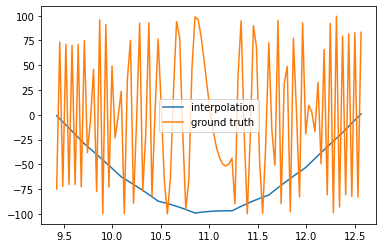

In [53]:
plt.plot(post_mean['x'], post_mean['f(x)'], label='interpolation')
plt.plot(post_mean['x'], test_data_function(post_mean['f(x)']), label='ground truth')
plt.legend()

# Prior Mean Functions
### NOTE: The prior mean function must return a 1d vector, e.g., (100,)

In [69]:
def example_mean(gp_obj,x,hyperparameters):
    return np.sin(x[:,0]/0.001)

In [70]:
obj = gp.GP(input_space_dim = 1, points = x_input.reshape(-1,1),
                            values = y_output.reshape(-1,1),
                           init_hyperparameters = np.array([10,10]),
                            variances = np.zeros(y_output.reshape(-1,1).shape),
                            gp_mean_function = example_mean)

## Training our gaussian process regression on given data


In [71]:
hyper_param_bounds = np.array([[0.0001, 1000],[ 0.0001, 1000]])
obj.train(hyper_param_bounds)

fvGP training started with  100  data points
fvGP hyperparameter tuning in progress. Old hyperparameters:  [10 10]  with old log likelihood:  47215.66878437307
method:  global
fvGP is performing a global differential evolution algorithm to find the optimal hyperparameters.
maximum number of iterations:  120
termination tolerance:  0.1
bounds:  [[1.e-04 1.e+03]
 [1.e-04 1.e+03]]
differential_evolution step 1: f(x)= 2005.7
differential_evolution step 2: f(x)= 1572.08
differential_evolution step 3: f(x)= 522.044
differential_evolution step 4: f(x)= 507.854
differential_evolution step 5: f(x)= 507.854
differential_evolution step 6: f(x)= 507.854
differential_evolution step 7: f(x)= 504.476
differential_evolution step 8: f(x)= 496.283
differential_evolution step 9: f(x)= 492.503
differential_evolution step 10: f(x)= 492.503
differential_evolution step 11: f(x)= 492.503
differential_evolution step 12: f(x)= 492.503
differential_evolution step 13: f(x)= 492.503
differential_evolution step 14:

## Looking the posterior mean at the test points

In [72]:
post_mean= obj.posterior_mean(x_input_test.reshape(-1,1))

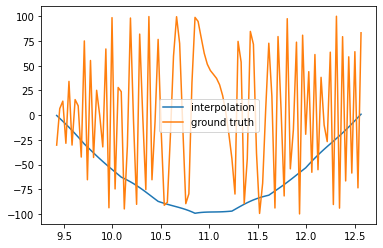

In [73]:
plt.plot(post_mean['x'], post_mean['f(x)'], label='interpolation')
plt.plot(post_mean['x'], test_data_function(post_mean['f(x)']), label='ground truth')
plt.legend()

# Putting it altogether
All previous optional gaussian process components can be combined during the class instantiation

In [87]:
obj = gp.GP(input_space_dim = 1, points = x_input.reshape(-1,1),
                            values = y_output.reshape(-1,1),
                           init_hyperparameters = np.array([10,10]), 
                            variances = np.zeros(y_output.reshape(-1,1).shape), 
                            normalize_y = True,
                            gp_kernel_function = kernel_l1,
                            gp_mean_function = example_mean)

In [88]:
hyper_param_bounds = np.array([[0.0001, 1000],[ 0.0001, 1000]])
obj.train(hyper_param_bounds)

fvGP training started with  100  data points
fvGP hyperparameter tuning in progress. Old hyperparameters:  [10 10]  with old log likelihood:  195.00941327717902
method:  global
fvGP is performing a global differential evolution algorithm to find the optimal hyperparameters.
maximum number of iterations:  120
termination tolerance:  0.1
bounds:  [[1.e-04 1.e+03]
 [1.e-04 1.e+03]]
differential_evolution step 1: f(x)= 172.692
differential_evolution step 2: f(x)= 172.624
fvGP found hyperparameters  [8.68855482e-01 1.00000000e-04]  with likelihood  134.8649235630018  via global optimization


In [89]:
post_mean= obj.posterior_mean(x_input_test.reshape(-1,1))

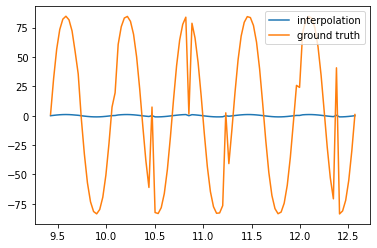

In [90]:
plt.plot(post_mean['x'], post_mean['f(x)'], label='interpolation')
plt.plot(post_mean['x'], test_data_function(post_mean['f(x)']), label='ground truth')
plt.legend()

# RANDOM TESTS

In [57]:
def hyperparams_test(obj):
    assert np.all(obj.hyperparameters >0) == True
hyperparams_test(obj)

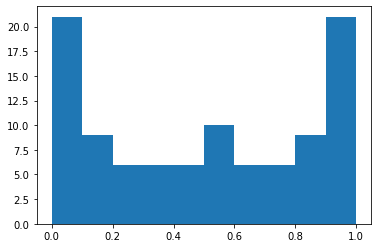

In [86]:
def normalize_y_test(obj):
    plt.hist(obj.data_y )
    plt.show()
    assert np.array_equal( obj.data_y <= 1, obj.data_y >= 0)
normalize_y_test(obj)

In [70]:
def correct_hyperparam_bounds_test(obj, hyperparam_bounds):
    assert len(obj.hyperparameters) == hyperparam_bounds.shape[0]
correct_hyperparam_bounds_test(obj, hyper_param_bounds)

In [76]:
def data_correct_shape_test(examples, dimensions, data):
    #Data here can be the inputs, associated outputs, or test positions
    assert data.shape[0] == examples
    assert data.shape[1] == dimensions
data_correct_shape_test(100, 1, np.array([y_output]).T) 